# RNN Sobre Datos Estáticos

# Sección 1: Configuración Inicial y Preparación de Datos

## 1.Importación de Librerías

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import recall_score, make_scorer, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import recall_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, ADASYN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.metrics import Recall as KerasRecall
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 2.Carga y División de Datos

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/credit_risk_cleanv6.csv')
X = df.drop(columns=["TARGET"])
y = df["TARGET"]

## 3.Preprocesamiento de Datos

In [ ]:

# Separar por tipo de dato
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Pipelines de preprocesamiento
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

# Aplicar transformación
X_proc = preprocessor.fit_transform(X)
X_proc = X_proc.toarray() if hasattr(X_proc, "toarray") else X_proc
X_proc = X_proc.reshape((X_proc.shape[0], 1, X_proc.shape[1]))

# Split
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, stratify=y, random_state=42)


# Sección 2: Fase de Modelado

## 1.GridSearch de Hiperparámetros

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.metrics import Recall as KerasRecall
from tensorflow.keras import backend as K
from scikeras.wrappers import KerasClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time

# -------------------------------
# Callback para registrar learning rate
# -------------------------------
class LearningRateLogger(Callback):
    def on_train_begin(self, logs=None):
        self.lrs = []
    def on_epoch_end(self, epoch, logs=None):
        lr = float(K.get_value(self.model.optimizer.learning_rate))
        self.lrs.append(lr)

# -------------------------------
# 1. Hiperparámetros (grilla)
# -------------------------------
param_grid = {
    # Capacidad de la capa RNN (número de unidades)
    "model__units": [32, 64, 128, 256],

    # Tasa de Dropout para regularización
    "model__dropout_rate": [0.2, 0.3, 0.4, 0.5],

    # Tamaño de cada batch durante entrenamiento
    "batch_size": [32, 64, 128],

    # Número máximo de épocas (EarlyStopping detendrá antes si no mejora)
    "epochs": [30, 50, 70, 100],

    # Proporción de los datos de entrenamiento para validación interna
    "validation_split": [0.1, 0.2, 0.3]
}


results = []

# -------------------------------
# 2. Loop de técnicas de balanceo
# -------------------------------
for method, sampler in {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'class_weight': None
}.items():

    print(f"\nTécnica de balanceo: {method}")

    # 2.1 Prepara X_res, y_res y class_weight
    if sampler:
        X_flat, y_flat = sampler.fit_resample(
            X_train.reshape(len(X_train), -1), y_train
        )
        X_res = X_flat.reshape(len(X_flat), 1, -1)
        y_res = y_flat
        class_weight = None
    else:
        X_res, y_res = X_train, y_train
        w = compute_class_weight('balanced', classes=np.unique(y_res), y=y_res)
        class_weight = dict(enumerate(w))

    # 2.2 Define RNN factory
    def create_rnn_model(units=32, dropout_rate=0.3):
        model = Sequential([
            SimpleRNN(units, input_shape=(1, X_res.shape[2])),
            BatchNormalization(),
            Dropout(dropout_rate),
            Dense(1, activation="sigmoid")
        ])
        model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=[KerasRecall(name="recall_clase_1")]
        )
        return model

    # 2.3 Configura el clasificador y GridSearch
    lr_logger = LearningRateLogger()
    base_clf = KerasClassifier(
        model=create_rnn_model,
        verbose=1,
        class_weight=class_weight,
        callbacks=[
            EarlyStopping(
                patience=3,
                restore_best_weights=True,
                monitor="val_recall_clase_1",
                mode="max"
            ),
            lr_logger
        ]
    )
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    grid = GridSearchCV(
        estimator=base_clf,
        param_grid=param_grid,
        scoring=make_scorer(recall_score, pos_label=1),
        cv=cv,
        n_jobs=-1
    )

    # 2.4 Ejecuta GridSearch y mide tiempo
    t0 = time.time()
    grid.fit(X_res, y_res)
    fit_minutes = (time.time() - t0) / 60

    # 3. Extrae los mejores hiperparámetros
    best_params = grid.best_params_
    units      = best_params["model__units"]
    dropout    = best_params["model__dropout_rate"]
    batch_size = best_params["batch_size"]
    epochs     = best_params["epochs"]
    val_split  = best_params["validation_split"]

    # 4. Reentrena manualmente para capturar history
    lr_logger_final = LearningRateLogger()
    es = EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor="val_recall_clase_1",
        mode="max"
    )
    final_model = create_rnn_model(units=units, dropout_rate=dropout)
    history = final_model.fit(
        X_res, y_res,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=val_split,
        class_weight=class_weight,
        callbacks=[es, lr_logger_final],
        verbose=0
    )
    hist_dict = history.history

    # 5. Predicción y métrica en test
    y_prob = final_model.predict(X_test).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    rec    = recall_score(y_test, y_pred, pos_label=1)

    # 6. Guardar todo en results
    results.append({
        "Técnica":             method,
        "Mejores parámetros":  best_params,
        "Recall test clase 1": rec,
        "Tiempo (min)":        round(fit_minutes, 2),
        "Modelo":              final_model,
        "Historial":           hist_dict,
        "Probabilidades":      y_prob,
        "Predicciones":        y_pred,
        "LR Logger":           lr_logger_final
    })



Técnica de balanceo: SMOTE


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


# Sección 3: Evaluación Básica del Modelo

## 1.Curvas de Aprendizaje Comparativas

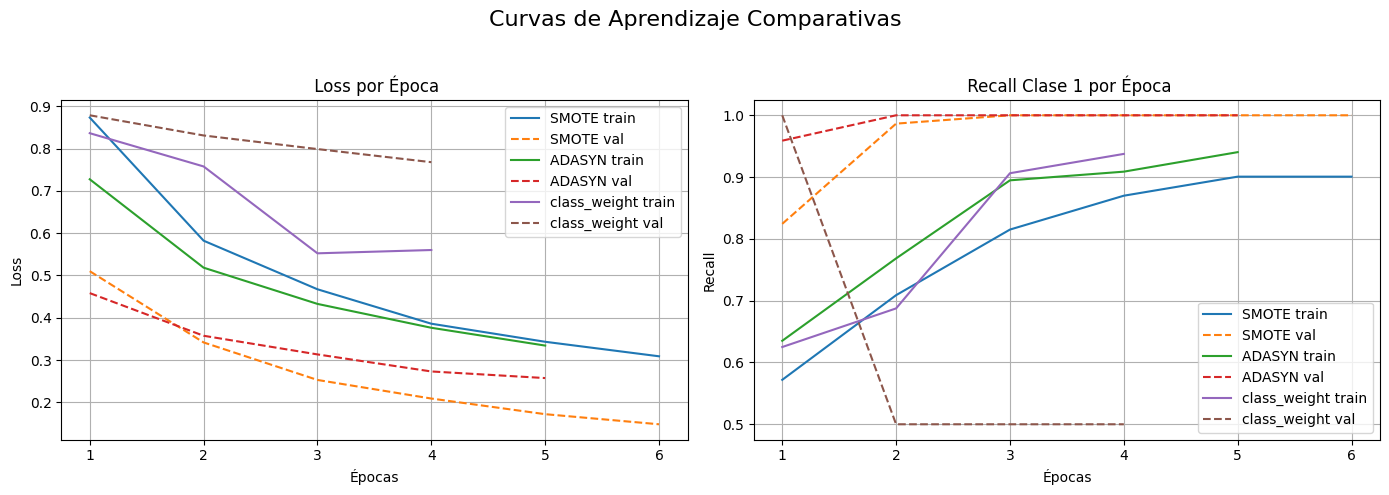

In [ ]:
import matplotlib.pyplot as plt

# Extraer el mayor número de épocas registrado
max_epochs = max(len(h.get("loss", [])) for h in
                 (r["Historial"] for r in results) if isinstance(h, dict))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ——— 1) Loss conjunta ———
for r in results:
    hist = r["Historial"] or {}
    label = r["Técnica"]
    epochs = range(1, len(hist.get("loss", [])) + 1)
    axes[0].plot(epochs, hist.get("loss", []), label=f"{label} train")
    axes[0].plot(epochs, hist.get("val_loss", []), linestyle="--", label=f"{label} val")

axes[0].set_title(" Loss por Época")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# ——— 2) Recall conjunta ———
for r in results:
    hist = r["Historial"] or {}
    label = r["Técnica"]
    epochs = range(1, len(hist.get("recall_clase_1", [])) + 1)
    axes[1].plot(epochs, hist.get("recall_clase_1", []), label=f"{label} train")
    axes[1].plot(epochs, hist.get("val_recall_clase_1", []),
                 linestyle="--", label=f"{label} val")

axes[1].set_title(" Recall Clase 1 por Época")
axes[1].set_xlabel("Épocas")
axes[1].set_ylabel("Recall")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Curvas de Aprendizaje Comparativas", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 2.Tabla de Hiperparámetros Óptimos por Técnica de Balanceo

In [ ]:
# 1) Construir lista de filas con hiperparámetros por técnica
hiperparametros_optimos = []
for r in results:
    params = r.get("Mejores parámetros", {})
    hiperparametros_optimos.append({
        "Técnica":       r.get("Técnica"),
        "Units":         params.get("model__units"),
        "Dropout":       params.get("model__dropout_rate"),
        "Batch size":    params.get("batch_size"),
        "Epochs":        params.get("epochs"),
        "Valid. split":  params.get("validation_split")
    })

# 2) Crear DataFrame y poner la columna Técnica como índice
df_hiper = pd.DataFrame(hiperparametros_optimos).set_index("Técnica")

# 3) Mostrar con formato
display(
    df_hiper.style
    .format({
        "Units":        "{:.0f}",
        "Dropout":      "{:.2f}",
        "Batch size":   "{:.0f}",
        "Epochs":       "{:.0f}",
        "Valid. split": "{:.2f}"
    })
)


,Units,Dropout,Batch size,Epochs,Valid. split
Técnica,,,,,
SMOTE,32,0.20,32,30,0.10
ADASYN,32,0.20,32,30,0.10
class_weight,32,0.20,32,30,0.10


## 3.Métricas de Desempeño del Modelo

### 3.1. Evaluación del desempeño sin Técnicas de Balanceo.

,Recall,Precision,F1-score,AUC,Tiempo (min)
Técnica,,,,,
SMOTE,0.5556,0.1136,0.1887,0.5031,0.44
ADASYN,0.6667,0.1132,0.1935,0.5836,0.21
class_weight,0.6667,0.1071,0.1846,0.6178,0.19


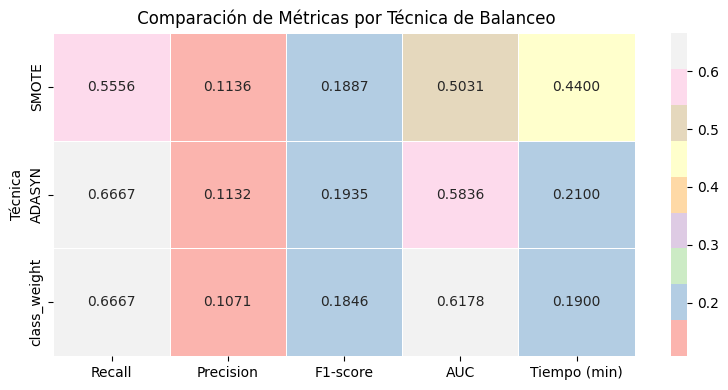

In [ ]:
import warnings

# Suprimir TODOS los warnings (matplotlib, seaborn, keras, etc.)
warnings.filterwarnings("ignore")

# Crear lista con métricas por técnica
metricas = []

for r in results:
    y_pred = r["Predicciones"]
    y_prob = r["Probabilidades"]

    metricas.append({
        "Técnica": r["Técnica"],
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "F1-score": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob),
        "Tiempo (min)": r["Tiempo (min)"]
    })

# Convertir a DataFrame y mostrar con formato
df_metricas = pd.DataFrame(metricas).set_index("Técnica")
df_metricas = df_metricas.round(4)


# Mostrar tabla
display(df_metricas)

# Visualización opcional como heatmap (valores más altos en verde)
plt.figure(figsize=(8, 4))
sns.heatmap(df_metricas, annot=True, cmap="Pastel1", fmt=".4f", linewidths=0.5)
plt.title(" Comparación de Métricas por Técnica de Balanceo")
plt.tight_layout()
plt.show()


### 3.2. Evaluación Visual del desempeño sin Técnicas de Balanceo.

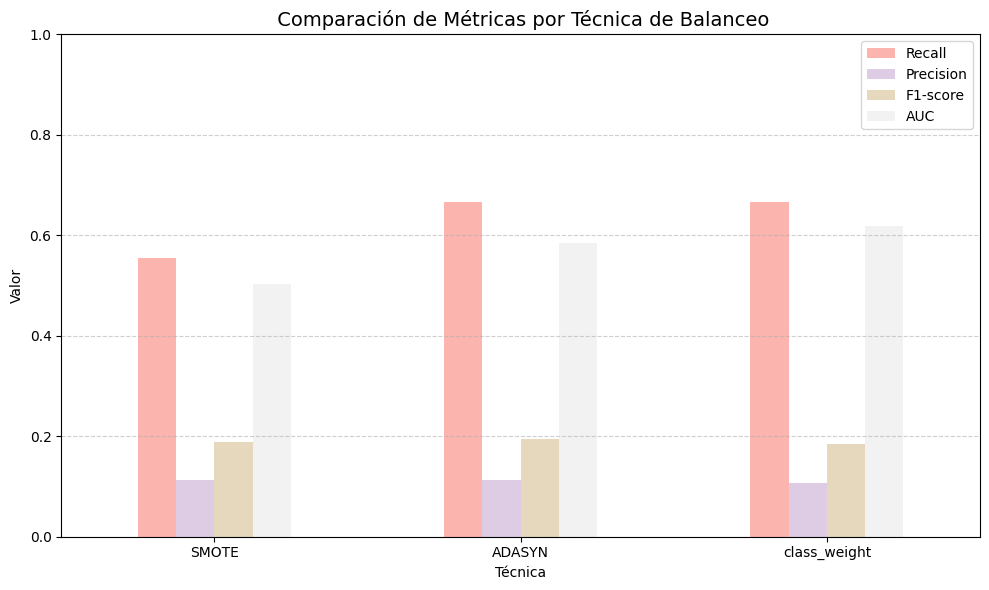

In [ ]:
import warnings

# Suprimir TODOS los warnings (matplotlib, seaborn, keras, etc.)
warnings.filterwarnings("ignore")

# Recolectar métricas
metricas = []

for r in results:
    y_pred = r["Predicciones"]
    y_prob = r["Probabilidades"]

    metricas.append({
        "Técnica": r["Técnica"],
        "Recall": recall_score(y_test, y_pred, pos_label=1),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "F1-score": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob)
    })

# Crear DataFrame
df_metricas = pd.DataFrame(metricas).set_index("Técnica").round(4)

# Graficar
df_metricas.plot(kind="bar", figsize=(10, 6), colormap="Pastel1", rot=0)
plt.title(" Comparación de Métricas por Técnica de Balanceo", fontsize=14)
plt.ylabel("Valor")
plt.xlabel("Técnica")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## 4.Matrices de Confusión por Técnica de Balanceo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


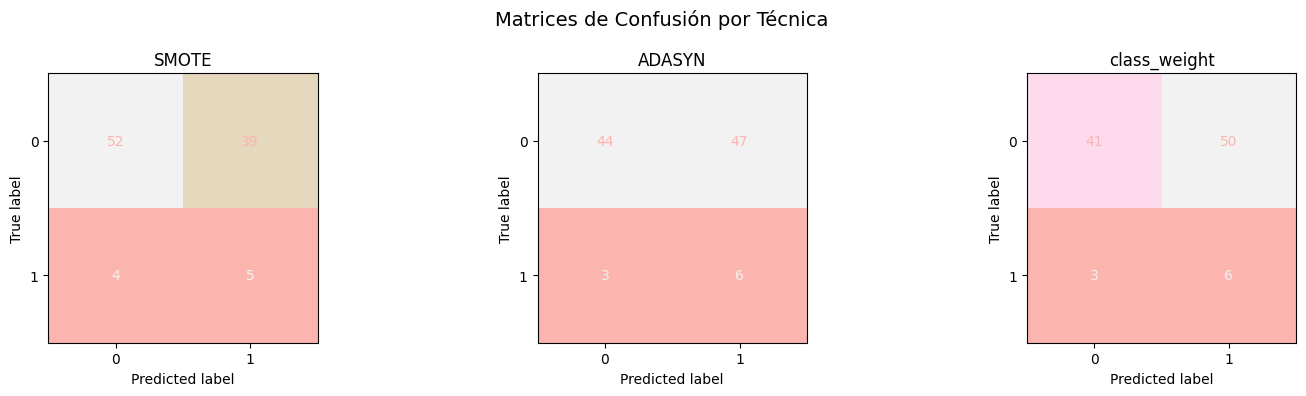

In [ ]:
# Filtrar modelos válidos
modelos_validos = [r for r in results if r.get("Modelo")]

# Crear figura con subplots: 1 fila, 3 columnas
fig, axes = plt.subplots(1, len(modelos_validos), figsize=(5 * len(modelos_validos), 4))

# Si solo hay un modelo, convertir axes a lista
if len(modelos_validos) == 1:
    axes = [axes]

for ax, r in zip(axes, modelos_validos):
    model = r["Modelo"]
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap="Pastel1", values_format="d", colorbar=False)
    ax.set_title(f"{r['Técnica']}", fontsize=12)
    ax.grid(False)

plt.suptitle("Matrices de Confusión por Técnica", fontsize=14)
plt.tight_layout()
plt.show()


## 5.Curva ROC por Técnica de Balanceo

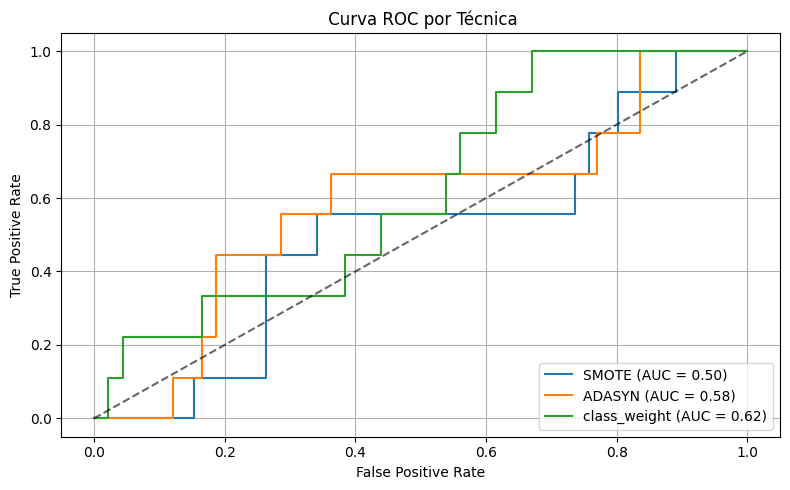

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 5))

for r in results:
    y_prob = r.get("Probabilidades")
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{r['Técnica']} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.title(" Curva ROC por Técnica")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## 6.Curva Precision vs Recall comparativa

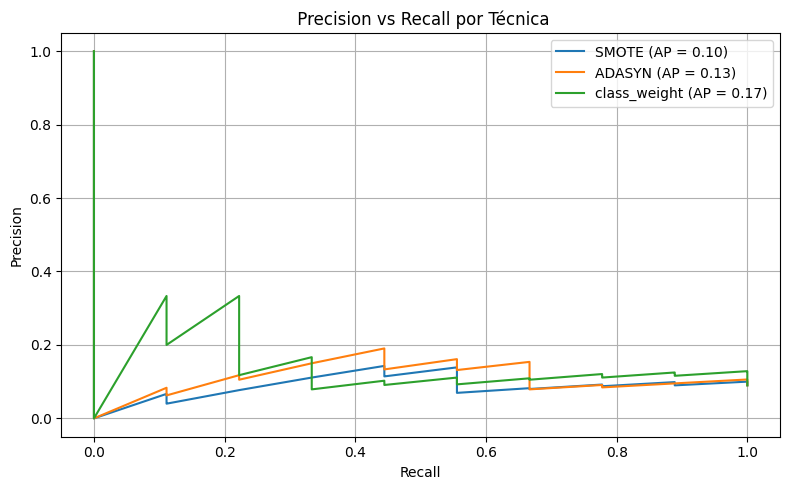

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 5))

for r in results:
    y_prob = r.get("Probabilidades")
    if y_prob is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        ap = average_precision_score(y_test, y_prob)
        plt.plot(recall, precision, label=f"{r['Técnica']} (AP = {ap:.2f})")

plt.title(" Precision vs Recall por Técnica")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 7.Curva KS (Kolmogorov–Smirnov)

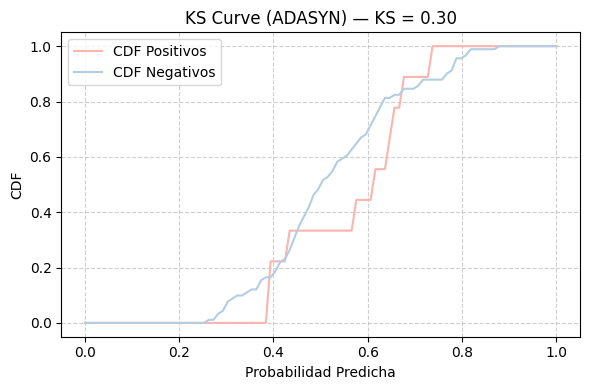

In [ ]:
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# 1) Seleccionar la técnica óptima según Recall en test
best_entry = max(results, key=lambda r: r["Recall test clase 1"])
opt_method = best_entry["Técnica"]
prob = best_entry["Probabilidades"]

# 2) Separar probabilidades por clase real
y_arr = np.array(y_test)
pos = prob[y_arr == 1]
neg = prob[y_arr == 0]

# 3) Calcular CDFs
x = np.linspace(0, 1, 100)
cdf_pos = [np.mean(pos <= xi) for xi in x]
cdf_neg = [np.mean(neg <= xi) for xi in x]

# 4) Estadístico KS
ks_stat, ks_p = ks_2samp(pos, neg)

# 5) Graficar
plt.figure(figsize=(6, 4))
plt.plot(x, cdf_pos, label="CDF Positivos", color=plt.get_cmap("Pastel1")(0))
plt.plot(x, cdf_neg, label="CDF Negativos", color=plt.get_cmap("Pastel1")(1))
plt.title(f"KS Curve ({opt_method}) — KS = {ks_stat:.2f}")
plt.xlabel("Probabilidad Predicha")
plt.ylabel("CDF")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# Sección 4: Evaluación Avanzada del Modelo

## 1.Curva de Ganancias Acumuladas / Lift Chart

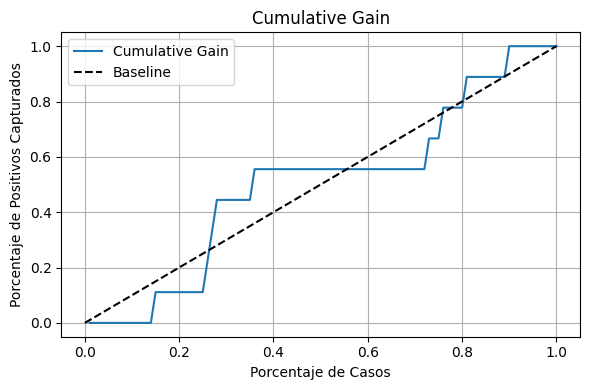

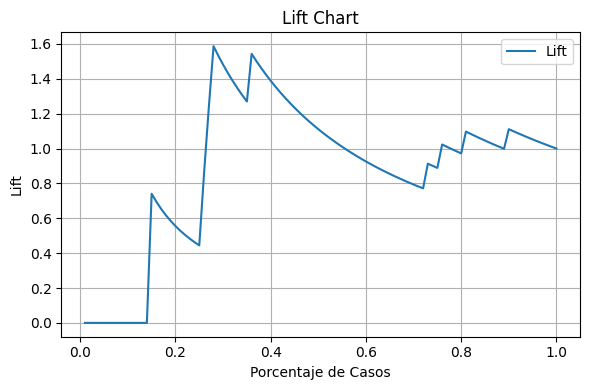

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# concatenar clases y probabilidades
df_gain = pd.DataFrame({
    "y": y_test,
    "prob": [r["Probabilidades"] for r in results if r["Técnica"]=="SMOTE"][0]  # cambia técnica si quieres comparar varias
}).sort_values("prob", ascending=False)
df_gain["cum_pos"] = df_gain["y"].cumsum()
df_gain["perc_pos"] = df_gain["cum_pos"] / df_gain["y"].sum()
df_gain["cum_total"] = np.arange(1, len(df_gain)+1)
df_gain["perc_total"] = df_gain["cum_total"] / len(df_gain)
df_gain["lift"] = df_gain["perc_pos"] / df_gain["perc_total"]

plt.figure(figsize=(6,4))
plt.plot(df_gain["perc_total"], df_gain["perc_pos"], label="Cumulative Gain")
plt.plot([0,1],[0,1],"k--", label="Baseline")
plt.title("Cumulative Gain")
plt.xlabel("Porcentaje de Casos")
plt.ylabel("Porcentaje de Positivos Capturados")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(df_gain["perc_total"], df_gain["lift"], label="Lift")
plt.title("Lift Chart")
plt.xlabel("Porcentaje de Casos")
plt.ylabel("Lift")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2.Radar Plot de métricas por Técnica de Balanceo

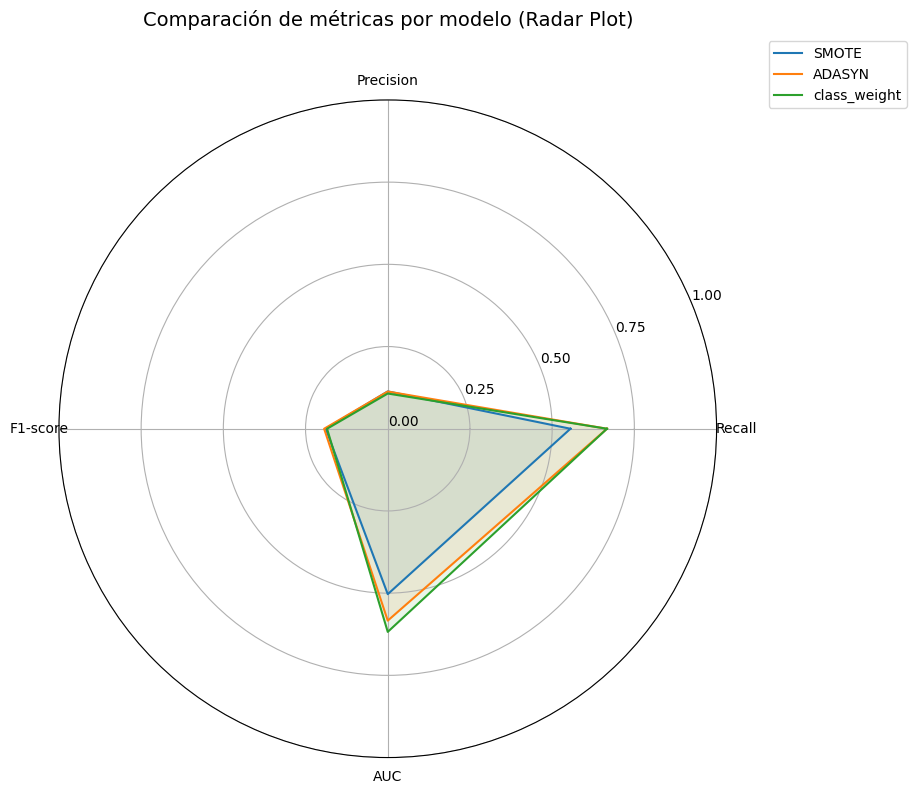

In [ ]:
# Preparar datos para radar plot
labels = df_metricas.columns.tolist()
num_vars = len(labels)

# Ángulos para cada eje
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

# Radar plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Dibujar una línea por técnica
for index, row in df_metricas.iterrows():
    values = row.tolist()
    values += values[:1]  # Cerrar el círculo
    ax.plot(angles, values, label=index)
    ax.fill(angles, values, alpha=0.1)

# Etiquetas
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks(np.linspace(0, 1, 5))
ax.set_ylim(0, 1)

ax.set_title("Comparación de métricas por modelo (Radar Plot)", y=1.1, fontsize=14)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("radar_plot_metricas.png")
plt.show()


## 3.Heatmap de Recall por Units y Dropout

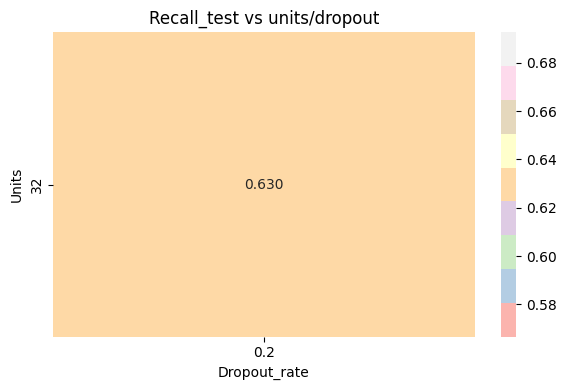

In [ ]:
# Extraer en un DataFrame
rows = []
for r in results:
    bp = r["Mejores parámetros"]
    rows.append({
        "Técnica":       r["Técnica"],
        "units":         bp["model__units"],
        "dropout":       bp["model__dropout_rate"],
        "batch_size":    bp["batch_size"],
        "epochs":        bp["epochs"],
        "val_split":     bp["validation_split"],
        "recall_test":   r["Recall test clase 1"],
        "auc_test":      roc_auc_score(y_test, r["Probabilidades"])
    })

df_report = pd.DataFrame(rows)

# Pivot ejemplo: recall vs units & dropout
pivot = df_report.pivot_table(
    index="units", columns="dropout", values="recall_test"
)
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, cmap="Pastel1", fmt=".3f")
plt.title("Recall_test vs units/dropout")
plt.ylabel("Units")
plt.xlabel("Dropout_rate")
plt.tight_layout()
plt.show()


## 4.Gráfico de Barras del Tiempo de Entrenamiento

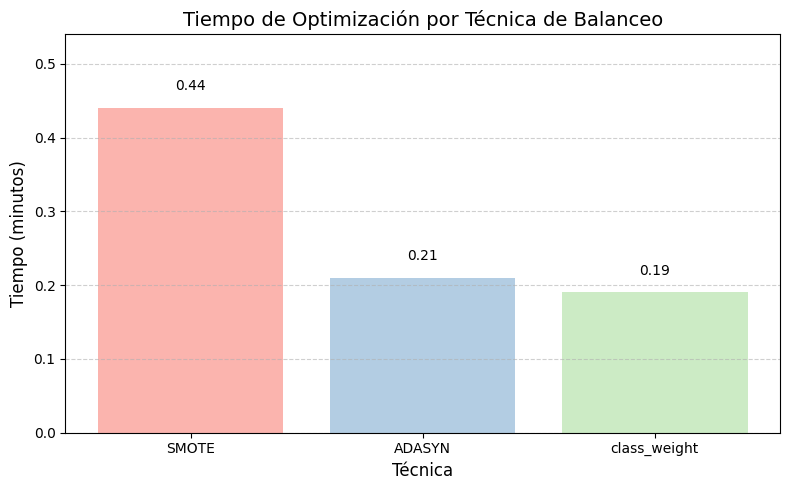

In [ ]:
import matplotlib.pyplot as plt

# Asegurarse de tener df_resultados
df_resultados = pd.DataFrame(results)

# Establecer paleta Pastel1
colors = plt.get_cmap("Pastel1").colors[:len(df_resultados)]

# Crear gráfico de barras verticales
plt.figure(figsize=(8, 5))
bars = plt.bar(
    df_resultados["Técnica"],
    df_resultados["Tiempo (min)"],
    color=colors
)

# Calcular el límite superior del eje y para dejar margen
max_height = max([bar.get_height() for bar in bars])
plt.ylim(0, max_height + 0.1)

# Etiquetas y estilo
plt.title("Tiempo de Optimización por Técnica de Balanceo", fontsize=14)
plt.xlabel("Técnica", fontsize=12)
plt.ylabel("Tiempo (minutos)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Mostrar valores arriba de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## 5.Curva de Calibración (Reliability Diagram)

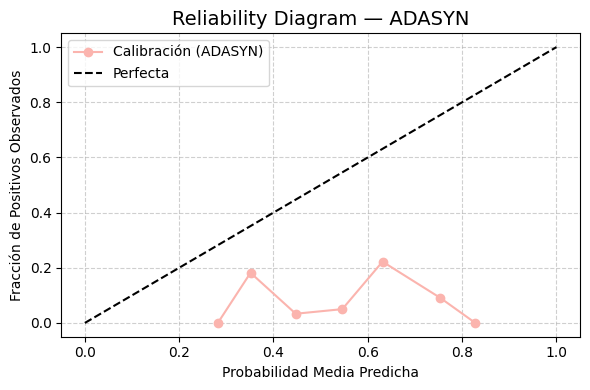

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# 1) Seleccionar el mejor modelo según Recall test obtenido por GridSearchCV
best_entry = max(results, key=lambda r: r["Recall test clase 1"])
opt_method = best_entry["Técnica"]
prob       = best_entry["Probabilidades"]

# 2) Calcular la curva de calibración
#    frac_true: fracción de positivos observados en cada bin
#    frac_pred: probabilidad media predicha en cada bin
frac_true, frac_pred = calibration_curve(y_test, prob, n_bins=10)

# 3) Graficar el Reliability Diagram basado en el modelo óptimo
plt.figure(figsize=(6, 4))
plt.plot(frac_pred, frac_true, 'o-', label=f"Calibración ({opt_method})", color=plt.get_cmap("Pastel1")(0))
plt.plot([0, 1], [0, 1], 'k--', label="Perfecta")
plt.title(f"Reliability Diagram — {opt_method}", fontsize=14)
plt.xlabel("Probabilidad Media Predicha")
plt.ylabel("Fracción de Positivos Observados")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## 6.Curvas de Validación (Validation Curves)

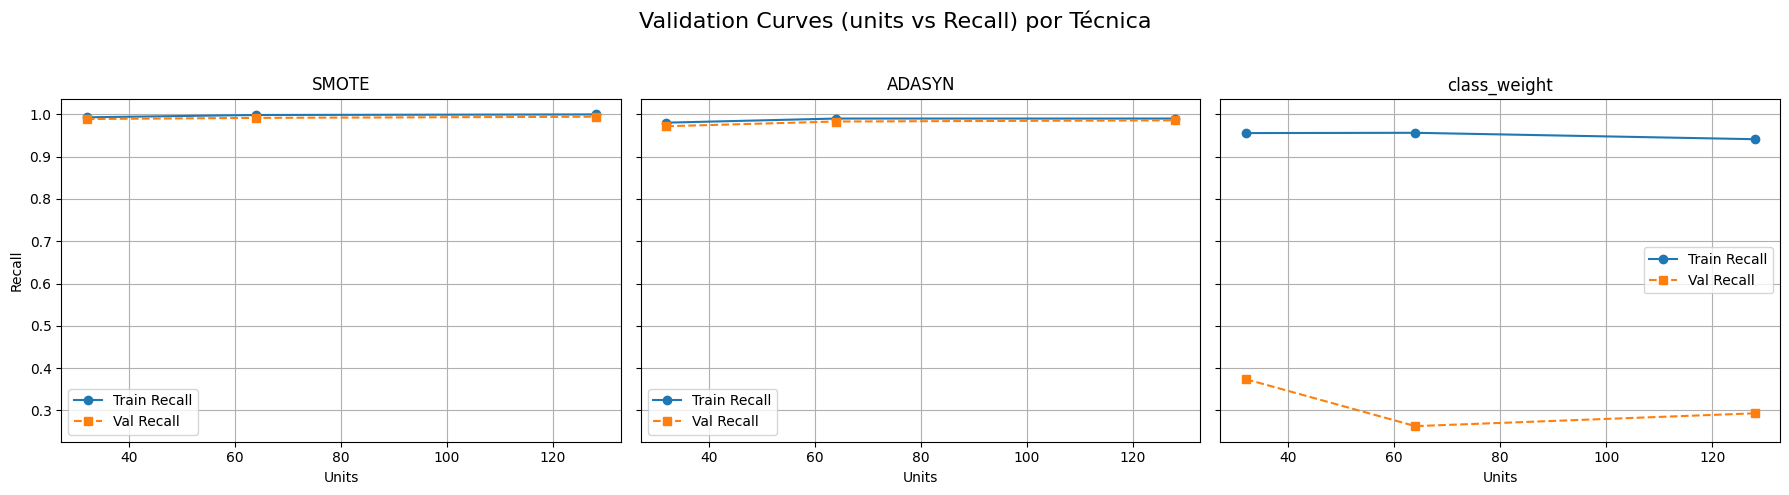

In [ ]:
from sklearn.model_selection import validation_curve, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, ADASYN
from scikeras.wrappers import KerasClassifier
import numpy as np
import matplotlib.pyplot as plt

# Define el rango de unidades para la validation curve
param_range = [32, 64, 128]

# Mapear cada técnica a su sampler
samplers = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'class_weight': None
}

# Crear figura con 1 fila y 3 columnas
fig, axes = plt.subplots(1, len(results), figsize=(18, 5), sharey=True)

for ax, r in zip(axes, results):
    tecnica     = r["Técnica"]
    best_params = r["Mejores parámetros"]
    sampler     = samplers[tecnica]

    # Reconstruir X_res, y_res según la técnica
    if sampler:
        X_flat, y_flat = sampler.fit_resample(
            X_train.reshape(len(X_train), -1), y_train
        )
        Xr = X_flat.reshape(len(X_flat), 1, -1)
        yr = y_flat
        cw = None
    else:
        Xr, yr = X_train, y_train
        w = compute_class_weight('balanced', classes=np.unique(yr), y=yr)
        cw = dict(enumerate(w))

    # Definir el clasificador con los mejores hiperparámetros (fijando todo menos units)
    clf_vc = KerasClassifier(
        model=create_rnn_model,
        verbose=0,
        class_weight=cw,
        model__dropout_rate=best_params["model__dropout_rate"],
        batch_size=        best_params["batch_size"],
        epochs=            best_params["epochs"],
        validation_split=  best_params["validation_split"]
    )

    # Calcular validation curve variando únicamente 'model__units'
    train_scores, val_scores = validation_curve(
        estimator=clf_vc,
        X=Xr, y=yr,
        param_name="model__units",
        param_range=param_range,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring=make_scorer(recall_score, pos_label=1),
        n_jobs=-1
    )

    # Promedios
    train_mean = np.mean(train_scores, axis=1)
    val_mean   = np.mean(val_scores,   axis=1)

    # Graficar en el subplot correspondiente
    ax.plot(param_range, train_mean, 'o-', label="Train Recall")
    ax.plot(param_range, val_mean,   's--', label="Val Recall")
    ax.set_title(f"{tecnica}")
    ax.set_xlabel("Units")
    if ax is axes[0]:
        ax.set_ylabel("Recall")
    ax.legend()
    ax.grid(True)

plt.suptitle("Validation Curves (units vs Recall) por Técnica", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 7.Curva de Aprendizaje vs Tamaño de Muestra

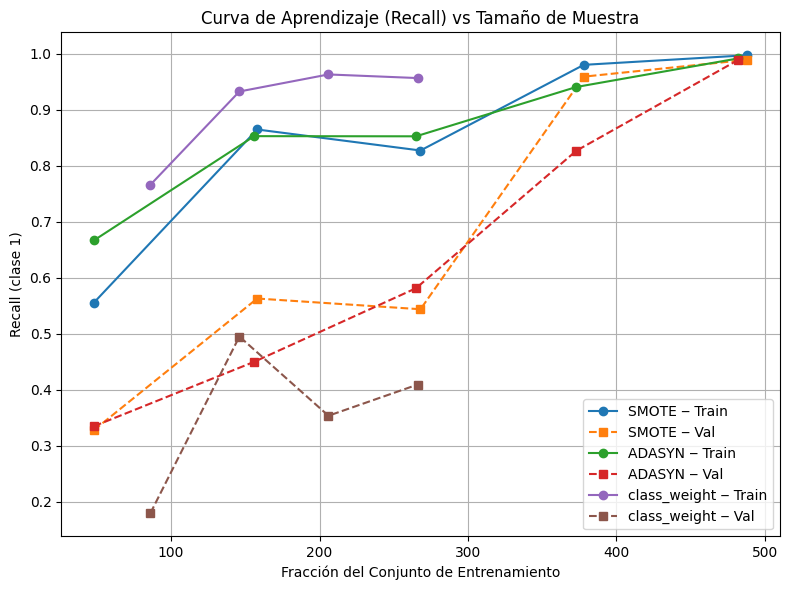

In [ ]:
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier
import numpy as np
import matplotlib.pyplot as plt

# Mapa de técnicas a sus samplers
samplers = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'class_weight': None
}

plt.figure(figsize=(8, 6))

for r in results:
    tecnica     = r["Técnica"]
    best_params = r["Mejores parámetros"]
    sampler     = samplers[tecnica]

    # 1) Recrear X_res, y_res para esta técnica
    if sampler:
        X_flat, y_flat = sampler.fit_resample(
            X_train.reshape(len(X_train), -1), y_train
        )
        Xr = X_flat.reshape(len(X_flat), 1, -1)
        yr = y_flat
        cw = None
    else:
        Xr, yr = X_train, y_train
        w = compute_class_weight('balanced', classes=np.unique(yr), y=yr)
        cw = dict(enumerate(w))

    # 2) Definir KerasClassifier con hiperparámetros óptimos
    clf = KerasClassifier(
        model=create_rnn_model,
        verbose=0,
        class_weight=cw,
        model__units=        best_params["model__units"],
        model__dropout_rate= best_params["model__dropout_rate"],
        epochs=              best_params["epochs"],
        batch_size=          best_params["batch_size"],
        validation_split=    best_params["validation_split"]
    )

    # 3) Calcular curva de aprendizaje
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=clf,
        X=Xr, y=yr,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring=make_scorer(recall_score, pos_label=1),
        n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean   = np.mean(val_scores,   axis=1)

    # 4) Plot comparativo
    plt.plot(train_sizes, train_mean,   marker='o', label=f"{tecnica} ‒ Train")
    plt.plot(train_sizes, val_mean,     linestyle='--', marker='s', label=f"{tecnica} ‒ Val")

plt.title("Curva de Aprendizaje (Recall) vs Tamaño de Muestra")
plt.xlabel("Fracción del Conjunto de Entrenamiento")
plt.ylabel("Recall (clase 1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 8.Tabla de “Threshold Analysis”

In [ ]:
# 1) Seleccionar el mejor modelo según Recall test
best_entry = max(results, key=lambda r: r["Recall test clase 1"])
prob       = best_entry["Probabilidades"]

# 2) Generar la tabla de threshold analysis
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0, 1, 11)
rows = []
for thr in thresholds:
    y_thr = (prob > thr).astype(int)
    rows.append({
        "threshold": thr,
        "precision": precision_score(y_test, y_thr, zero_division=0),
        "recall":    recall_score(y_test, y_thr, pos_label=1),
        "f1":        f1_score(y_test, y_thr, zero_division=0)
    })

df_thresh = pd.DataFrame(rows).set_index("threshold").round(3)
display(df_thresh)


,precision,recall,f1
threshold,,,
0.0,0.090,1.000,0.165
0.1,0.090,1.000,0.165
0.2,0.090,1.000,0.165
0.3,0.096,1.000,0.175
0.4,0.084,0.778,0.152
0.5,0.113,0.667,0.194
0.6,0.152,0.556,0.238
0.7,0.067,0.111,0.083
0.8,0.000,0.000,0.000


## 9.Distribución de Predicciones

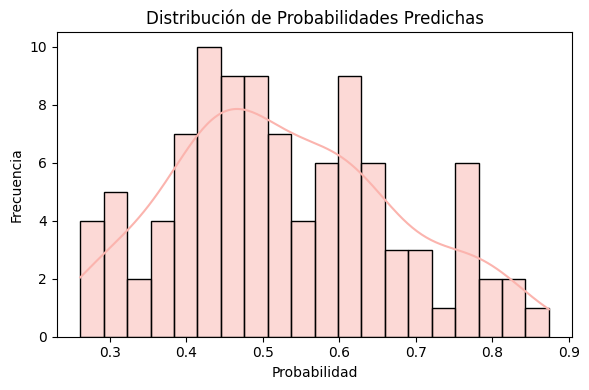

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.histplot(prob, bins=20, kde=True, color=sns.color_palette("Pastel1")[0])
plt.title("Distribución de Probabilidades Predichas")
plt.xlabel("Probabilidad")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


# Sección 5: Guardar Resultados

In [ ]:
import os
import pickle
import pandas as pd

# 1) Carpeta para guardar los modelos
os.makedirs("saved_models", exist_ok=True)

# 2) Guardar cada modelo Keras como archivo .h5
for r in results:
    tecnica = r["Técnica"]
    modelo  = r["Modelo"]
    path    = os.path.join("saved_models", f"rnn_{tecnica}.h5")
    modelo.save(path)
    print(f"🔖 Modelo '{tecnica}' guardado en {path}")

# 3) Guardar el listado completo de resultados (incluye dicts, history, etc.) como pickle
with open("results.pkl", "wb") as f:
    pickle.dump(results, f)
print("🔖 Lista completa de resultados guardada en results.pkl")

# 4) Crear un DataFrame de resumen y guardarlo como CSV
#    extraemos Técnica, Recall, Tiempo y los hiperparámetros óptimos
filas = []
for r in results:
    bp = r["Mejores parámetros"]
    filas.append({
        "Técnica":             r["Técnica"],
        "Recall test clase 1": r["Recall test clase 1"],
        "Tiempo (min)":        r["Tiempo (min)"],
        "units":               bp.get("model__units"),
        "dropout_rate":        bp.get("model__dropout_rate"),
        "batch_size":          bp.get("batch_size"),
        "epochs":              bp.get("epochs"),
        "validation_split":    bp.get("validation_split")
    })

df_summary = pd.DataFrame(filas)
df_summary.to_csv("results_summary.csv", index=False)
print("🔖 Resumen de resultados guardado en results_summary.csv")


🔖 Modelo 'SMOTE' guardado en saved_models/rnn_SMOTE.h5
🔖 Modelo 'ADASYN' guardado en saved_models/rnn_ADASYN.h5
🔖 Modelo 'class_weight' guardado en saved_models/rnn_class_weight.h5
🔖 Lista completa de resultados guardada en results.pkl
🔖 Resumen de resultados guardado en results_summary.csv
